# Heterogeneous Treatment Effect Estimation

A common goal in a causal model is to estimate the **average treatement effect** of some binary treatment variable $A \in \{0, 1\}$ on some observation variable $Y$. We denote the average treatement effect by $\tau$:

$$\tau = \mathbb{E}[Y | \operatorname{do}(A := 1)] - \mathbb{E}[Y | \operatorname{do}(A := 0)]$$

We are often interested in a more granular view of the effect of treatment. For some covariates $X$ in the causal model, we can find the average treatment effect conditioned on some assignment $x$ of $X$, which is called a **heterogeneous treatement effect** (also referred to as conditional average treatment effect, individual treatment effect, etc). This would look like:

$$\tau(x) = \mathbb{E}[Y | X = x, \operatorname{do}(A := 1)] - \mathbb{E}[Y | X = x, \operatorname{do}(A := 0)]$$

WhyNot generates an observational dataset $(X_i, A_i, Y_i)_{i=1}^n$ using a simulator, which allows us to also get individual-level counterfactuals $Y_{i, \operatorname{do}(A=0)}, Y_{i, \operatorname{do}(A=1)}$. This gives us the true heterogeneous treatment effect $\tau(x_i) = Y_{i, \operatorname{do}(A=1)} - Y_{i, \operatorname{do}(A=0)}$ of sample $i$, which we can compare to the estimated individual effect $\hat{\tau}(x_i)$ produced by some estimator. WhyNot provides a [collection of estimators](https://whynot-docs.readthedocs-hosted.com/en/latest/estimators.html#heterogeneous-treatment-effect-estimators) in the `causal_suite()` to estimate heterogeneous treatment effects. Each estimator returns an `InferenceResult` with the property `individual_effects`.

## Example

The code below shows how to use the causal forest estimator to estimate individual treatment effects for the `whynot.opioid.RCT` experiment.

### Generating dataset

First, we generate the observational dataset using the `opioid` simulator.

In [1]:
import whynot as wn
import numpy as np
import matplotlib.pyplot as plt
import heterogeneous_helper as helper
%matplotlib inline

experiment = wn.opioid.RCT

dataset = experiment.run(num_samples=200)

# dataset.true_effects is a length n vector of individual
# level contrasts Y_i(1) - Y_i(0)
dataset.true_effects[:10]

array([-57549.48894191, -57537.63031182, -57389.38749564, -56953.37053727,
       -57030.39817828, -56792.72686171, -56645.96480741, -57259.22456588,
       -57583.45613519, -56828.71239368])

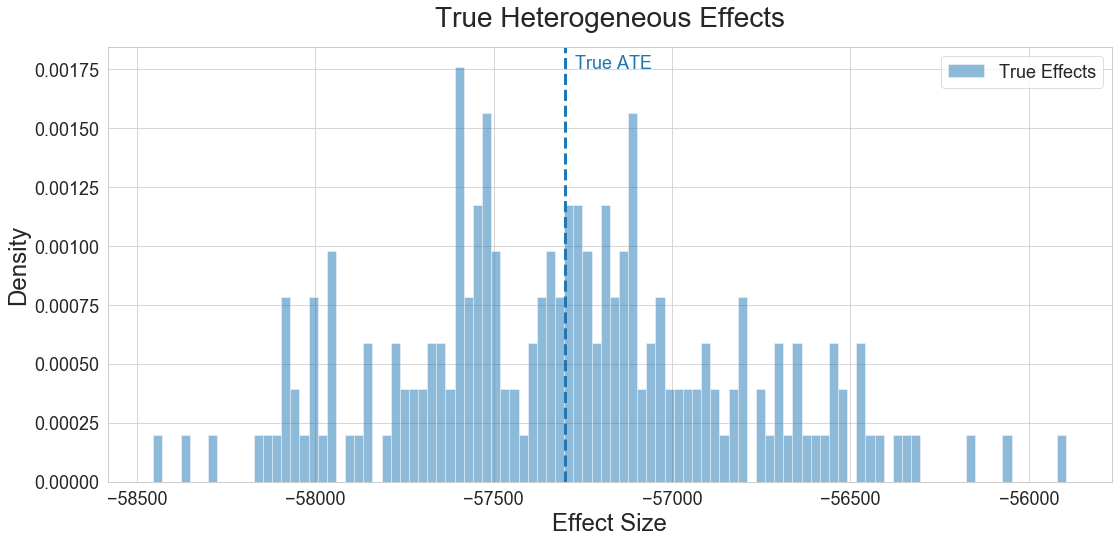

In [2]:
helper.effects_histogram(dataset.true_effects)

We can vary the sample size, as well as other parameters of the simulation. For this example, we will vary these parameters:

* `illicit_exit`: "Exit rate" of illicit opioid users (either stop using or die from non-opioid causes).
* `delta`: The percent decrease in new nonmedical users of prescription opioids when the treatment is applied (also called the nonmedical incidence delta).

Here is an interactive display of what the true effects look like under these changing conditions. Warning: generating the data takes a while.

In [3]:
helper.generate_data()
helper.effects_histogram_slider()

Output()

### Estimating heterogeneous treatment effects

Here, we use the causal forest estimator to estimate individual effects.

In [4]:
import whynot_estimators

# Estimate conditional ATE using a causal forest
estimate = whynot_estimators.causal_forest.estimate_treatment_effect(
    dataset.covariates,
    dataset.treatments,
    dataset.outcomes
)

# estimate.individual_effects is a length n vector
# of estimated individual level contrasts
estimate.individual_effects[:10]

[-55725.195118811534,
 -42586.47985326152,
 -47746.39620879929,
 -51753.45781479977,
 -56904.368504052865,
 -53072.91416477621,
 -55504.987410726906,
 -65234.28958999027,
 -63802.41704574131,
 -62738.07227589645]

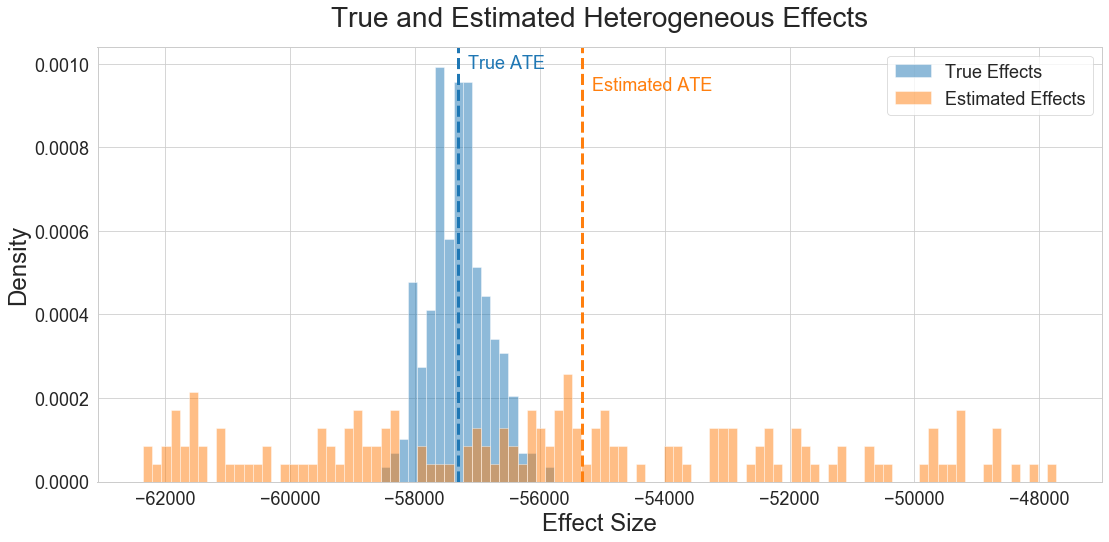

In [5]:
helper.effects_histogram(dataset.true_effects, estimate.individual_effects)

Here is a similar interactive visualization as before, with estimates:

In [6]:
helper.effects_histogram_slider(show_estimated_effects=True)

Output()

### Evaluating estimated HTEs

We can investigate the accuracy of the predicted heterogeneous treatment effects in various ways. Let the $n$-vector of true sample effects be denoted $\tau$ and the $n$-length vector of estimated sample effects be denoted $\hat{\tau}$.

First, we can take the "relative error" of the predictions:

$$hte\_error = \frac{||\hat{\tau} - \tau||_2}{||\tau||_2}$$

In [7]:
# Compute relative error for HTE estimates
hte_error = np.linalg.norm(estimate.individual_effects - dataset.true_effects) \
            / np.linalg.norm(dataset.true_effects)
print('hte_error:', hte_error)

hte_error: 0.1181725937698096


We can also look at these relative errors from simulator runs with different sample sizes. The shaded area around the plotted line is a 95% confidence interval bootstrapped from 20 iterations. Warning: This takes a while.

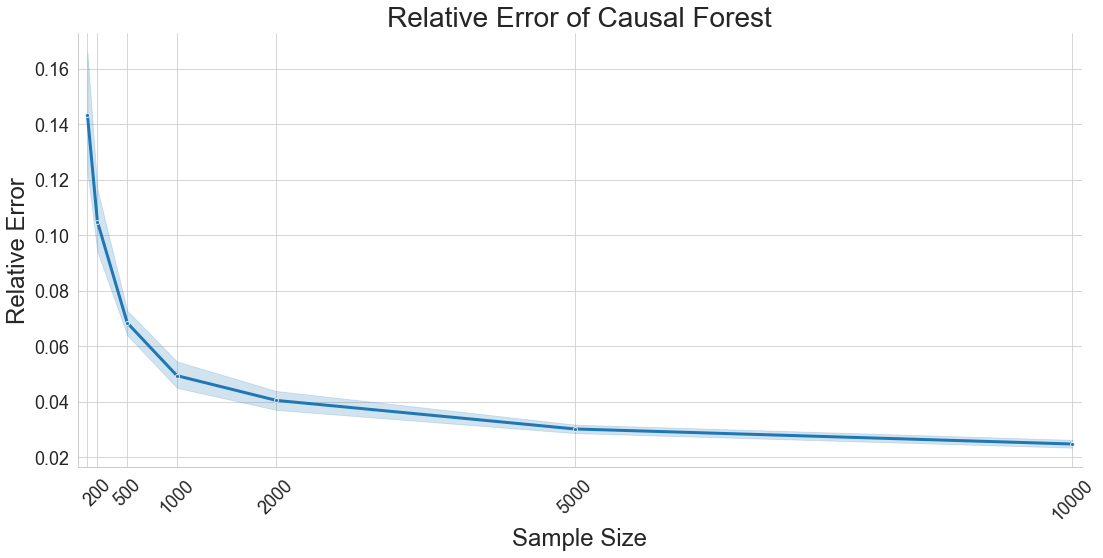

In [8]:
helper.generate_error_data()
helper.plot_relative_error()